https://www.cell.com/cms/10.1016/j.cell.2011.10.047/attachment/117b6d14-799a-4f63-ac31-d40a323ddefa/mmc1.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
S_A = np.loadtxt('../Hugo/S_A_100hr_sim_final.csv', delimiter = ',')
S_B = np.loadtxt('../Hugo/S_B_100hr_sim_final.csv', delimiter = ',')
print(S_A.shape, S_B.shape)
# dS_A = np.loadtxt('delta_S_A_100hr_sim_final.csv', delimiter = ',')
# dS_B = np.loadtxt('delta_S_B_100hr_sim_final.csv', delimiter = ',')
# print(dS_A.shape, dS_B.shape)

(6000, 420) (6003, 420)


In [3]:
S = np.concatenate((S_A, S_B), axis = 0)
# dS = np.concatenate((dS_A, dS_B), axis = 0)
print(S.shape)

(12003, 420)


In [4]:
def norm_S(S):
    normed_S = S.copy()
    normed_S -= np.min(normed_S)
    return normed_S

In [5]:
normalized_S = np.zeros(S.shape)

for i in range(len(S)):
    normed_S = norm_S(S[i])
    normalized_S[i] = normed_S 

In [6]:
conversion = 5/np.max(normalized_S)
print(conversion)

15465.039663558979


In [7]:
# parameters:
#commented these out because they will get passed into the model
# alpha = 3 # Pmax
# beta = 5 # Omax
# gamma = 5 # Nmax
# h1 = 6 # N repression of P strength
# h2 = 2 # O repression of P strength
# h3 = 5 # N repression of O strength

h4 = 1 # O rep of N str
h5 = 1 # P rep of N str
k1 = 1 # P degradation
k2 = 1 # O deg
k3 = 1 # N deg

# XcritY is the critical value of X for which y is half maximal
OcritP = 1
NcritP = 1
OcritN = 1
NcritO = 1
PcritN = 1
n = 1 # Hill coef of G on O
m = 1 # Hill coef of G on N

P0 = 3 # starting value for P
O0 = 0 # starting value for O
N0 = 0 # starting value for N

In [8]:
# ODEs:

#dP/dt
def dP(N, O, P, i, h1, h2, alpha):
    G = normalized_S[i] * conversion
    Nfrac = (N/NcritP)**h1
    Ofrac = (O/OcritP)**h2
    denom = 1 + Nfrac + Ofrac
    frac = alpha/denom
    return(frac-k1*P)

#dO/dt
def dO(N,O,P,i, h3, beta):
    G = normalized_S[i] * conversion
    Gterm = (beta*G)/(1+G)
    Nfrac = (N/NcritO)**h3
    frac = 1/(1+Nfrac)
    return(Gterm*frac-k2*O)
#dN/dt
def dN(N,O,P,i, gamma):
    G = normalized_S[i] * conversion
    Gterm = (gamma*G)/(1+G)
    Ofrac = (O/OcritN)**h4
    Pfrac = (P/PcritN)**h5
    frac = 1/(1+Ofrac+Pfrac)
    return(Gterm*frac - k3*N)

In [9]:
#function to run simulation given alpha, beta, gamma, h1, h2, and h3
def run_simulation(alpha, beta, gamma, h1, h2, h3):
    t = 20
    h = 0.002
    n = int(t/h)

    N = N0*np.zeros(420)
    O = O0*np.zeros(420)
    P = P0*np.zeros(420)
    #G = 5 # level used in Briscoe Paper

    ts = np.linspace(0,t,n)
    Ns = np.zeros((n, 420))
    Os = np.zeros((n, 420))
    Ps = np.zeros((n, 420))
    Ns[0] = N
    Os[0] = O
    Ps[0] = P
    for i in range(1,n):
        #calculate the rate of change for N, O, and P at current time point
        N_upd = dN(N, O, P, i, gamma);
        O_upd = dO(N, O, P, i, h3, beta);
        P_upd = dP(N, O, P, i, h1, h2, alpha);
        #add change to N, O, P
        N = N + h * N_upd;
        O = O + h * O_upd;
        P = P + h * P_upd;
        #store the new N, O, and P
        Ns[i] = N;
        Os[i] = O;
        Ps[i] = P;
    
    return Ns, Os, Ps, ts;

In [10]:
alpha = 3 # Pmax
beta = 5 # Omax
gamma = 5 # Nmax
h1 = 6 # N repression of P strength
h2 = 2 # O repression of P strength
h3 = 5 # N repression of O strength

#run simulation with given parameters
Ns, Os, Ps, ts = run_simulation(alpha, beta, gamma, h1, h2, h3);

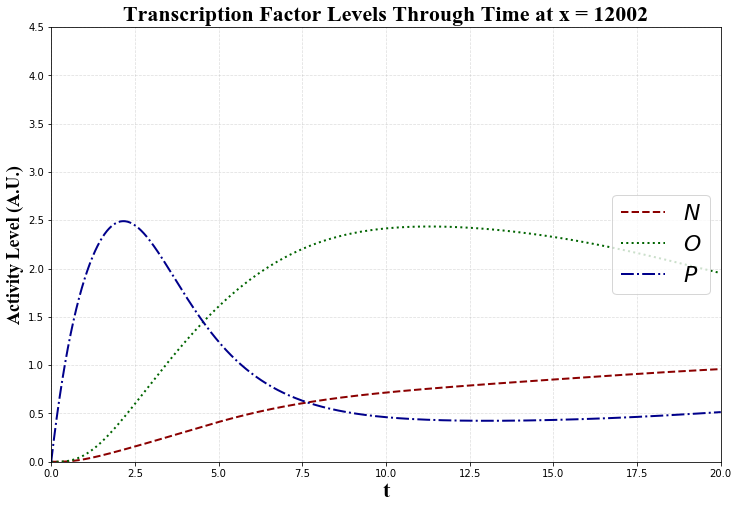

In [11]:
x = 120

plt.figure(figsize=(12,8))
myfont = {'fontname':'Times New Roman'}
plt.title('Transcription Factor Levels Through Time at x = {0}'.format(i),**myfont, fontsize = 22)
plt.plot(ts,Ns[:, x], label="$N$", color ='darkred', linestyle='--', linewidth=2)
plt.plot(ts,Os[:, x], label="$O$", color ='darkgreen', linestyle=':', linewidth=2)
plt.plot(ts,Ps[:, x], label="$P$", color ='darkblue', linestyle="-.", linewidth=2)
#plt.fill_between(ts,Ns,0, alpha = 0.15, color='red')
#plt.fill_between(ts,Os,0, alpha = 0.15, color='green')
#plt.fill_between(ts,Ps,0, alpha = 0.15, color='blue')
plt.legend(loc='center right', fontsize=22)
plt.margins(x=0, y=0)
plt.xlabel("t",**myfont, fontsize=22)
plt.ylabel("Activity Level (A.U.)",**myfont, fontsize=18)
plt.ylim((0,4.5))
plt.grid(True, lw=.75, ls='--', alpha=0.4)
plt.show()
# plt.savefig("model2_activity_time")

In [12]:
def calc_mean(N, O, P):
    x_points_more_N = [];
    x_points_more_O = [];
    x_points_more_P = [];
    
    for x in range(len(N)): #go through all the x points at the last time point
        if N[x] > O[x] and N[x] > P[x]: #this x-point highest level of Nkx2.2
            x_points_more_N.append(x);
        elif O[x] > N[x] and O[x] > P[x]: #this x-point highest level of Olig2
            x_points_more_O.append(x);
        elif P[x] > O[x] and P[x] > N[x]: #this x-point highest level of Pax6
            x_points_more_P.append(x);
    
    #check that there is at least one x-point in each list
    if len(x_points_more_N) == 0:
        x_points_more_N.append(np.inf);
    if len(x_points_more_O) == 0:
        x_points_more_O.append(np.inf);
    if len(x_points_more_P) == 0:
        x_points_more_P.append(np.inf);
        
    #return the mean x-value of each list
    return np.mean(x_points_more_N), np.mean(x_points_more_O), np.mean(x_points_more_P);
        

def grid_search(alpha_vals, beta_vals, gamma_vals, h1_vals, h2_vals, h3_vals):
    #save best values
    best_alpha = None;
    best_beta = None;
    best_gamma = None;
    best_h1 = None;
    best_h2 = None;
    best_h3 = None;
    best_score = np.inf;
    
    #desired mean x-points for N, O, P
    desired_N = np.sum(np.arange(1,71)) / 70;
    desired_O = np.sum(np.arange(71,141)) / 70;
    desired_P = np.sum( np.arange(141, 211)) / 70;
    
    for alpha in alpha_vals:
        for beta in beta_vals:
            for gamma in gamma_vals:
                for h1 in h1_vals:
                    for h2 in h2_vals:
                        for h3 in h3_vals:
                            #run the simulation for current parameters
#                             print("Trying {0}, {1}, {2}, {3}, {4}, {5}".format(alpha, beta, gamma, h1, h2, h3));
                            Ns, Os, Ps, ts = run_simulation(alpha, beta, gamma, h1, h2, h3);
                            #find the mean x-point for the peak of each transcription factor at the last time point
                            mean_N, mean_O, mean_P = calc_mean(Ns[-1], Os[-1], Ps[-1]);
                            #calculate the score for the difference between the desired mean and calculated mean
                            diff = np.array([mean_N, mean_O, mean_P]) - np.array([desired_N, desired_O, desired_P]);
                            score = np.linalg.norm(diff, ord=2);
                            if score < best_score: #update best parameters if score is better than best_score
                                best_alpha = alpha;
                                best_beta = beta;
                                best_gamma = gamma;
                                best_h1 = h1;
                                best_h2 = h2;
                                best_h3 = h3;
                                best_score = score;
    
    #return the best values
    return [best_alpha, best_beta, best_gamma, best_h1, best_h2, best_h3];

In [13]:
# alpha = 3 # Pmax
# beta = 5 # Omax
# gamma = 5 # Nmax
# h1 = 6 # N repression of P strength
# h2 = 2 # O repression of P strength
# h3 = 5 # N repression of O strength

#get range of values to test for h parameters
alpha_input = [3] #[2,3,4];
beta_input = [5] #[4,5,6];
gamma_input = [5] #[4,5,6];
h1_input = [1,2,3,4,5,6,7];
h2_input = [1,2,3,4];
h3_input = [3,4,5,6,7];

best_h_params = grid_search(alpha_input, beta_input, gamma_input, h1_input, h2_input, h3_input);
print(best_h_params)

[3, 5, 5, 7, 1, 3]


In [14]:
#get range of values to test for each parameter
alpha_input = [1, 2, 3, 4, 5];
beta_input = [3, 4, 5, 6, 7];
gamma_input = [3, 4, 5, 6, 7];
h1_input = [best_h_params[3]] #[5,6,7];
h2_input = [best_h_params[4]] #[1,2,3];
h3_input = [best_h_params[5]] # [4,5,6];

best_params = grid_search(alpha_input, beta_input, gamma_input, h1_input, h2_input, h3_input);
print(best_params)

[5, 4, 6, 7, 1, 3]


In [15]:
# alpha = 3 # Pmax
# beta = 5 # Omax
# gamma = 5 # Nmax
# h1 = 6 # N repression of P strength
# h2 = 2 # O repression of P strength
# h3 = 5 # N repression of O strength
print(best_params)
opt_Ns, opt_Os, opt_Ps, ts = run_simulation(*best_params);

[5, 4, 6, 7, 1, 3]


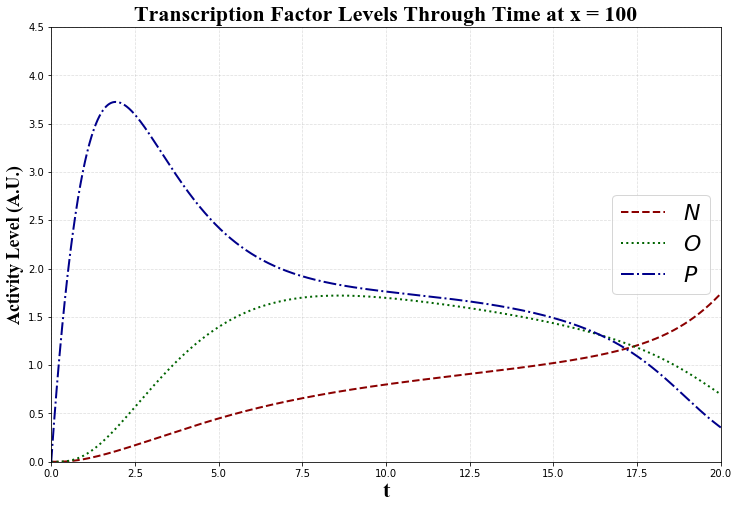

In [23]:
x = 100

plt.figure(figsize=(12,8))
myfont = {'fontname':'Times New Roman'}
plt.title('Transcription Factor Levels Through Time at x = {0}'.format(x),**myfont, fontsize = 22)
plt.plot(ts,opt_Ns[:, x], label="$N$", color ='darkred', linestyle='--', linewidth=2)
plt.plot(ts,opt_Os[:, x], label="$O$", color ='darkgreen', linestyle=':', linewidth=2)
plt.plot(ts,opt_Ps[:, x], label="$P$", color ='darkblue', linestyle="-.", linewidth=2)
#plt.fill_between(ts,Ns,0, alpha = 0.15, color='red')
#plt.fill_between(ts,Os,0, alpha = 0.15, color='green')
#plt.fill_between(ts,Ps,0, alpha = 0.15, color='blue')
plt.legend(loc='center right', fontsize=22)
plt.margins(x=0, y=0)
plt.xlabel("t",**myfont, fontsize=22)
plt.ylabel("Activity Level (A.U.)",**myfont, fontsize=18)
plt.ylim((0,4.5))
plt.grid(True, lw=.75, ls='--', alpha=0.4)
plt.show()
# plt.savefig("model2_activity_time")